In [213]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker                                                                                                                                                                                                                                                            
import matplotlib.dates as mdates

In [443]:
# Import raw data as pandas dataframe

q1_file = "/Users/aspelfrey/Desktop/CaseStudyCoursera/Data/Divvy_Trips_2019_Q1.csv"
q2_file = "/Users/aspelfrey/Desktop/CaseStudyCoursera/Data/Divvy_Trips_2019_Q2.csv"
q3_file = "/Users/aspelfrey/Desktop/CaseStudyCoursera/Data/Divvy_Trips_2019_Q3.csv"
q4_file = "/Users/aspelfrey/Desktop/CaseStudyCoursera/Data/Divvy_Trips_2019_Q4.csv"

df_q1 = pd.read_csv(q1_file)
df_q2 = pd.read_csv(q2_file)
df_q3 = pd.read_csv(q3_file)
df_q4 = pd.read_csv(q4_file)

In [444]:
# Data Cleaning

# Rename columns
"""
print("\n df_q1 Columns:\n", df_q1.dtypes)
print("\n df_q2 Columns:\n",df_q2.dtypes)
print("\n df_q3 Columns:\n",df_q3.dtypes)
print("\n df_q4 Columns:\n",df_q4.dtypes)
"""
q134_dict = {"bikeid":"bike_id", 
            "tripduration": "trip_duration",
            "from_station_id": "start_station_id",
            "from_station_name": "start_station_name",
            "to_station_id": "end_station_id",
            "to_station_name": "end_station_name",
            "usertype": "user_type",
            "birthyear":"birth_year"
            }
q2_dict = {"01 - Rental Details Rental ID" : "trip_id",
           "01 - Rental Details Local Start Time":"start_time", 
           "01 - Rental Details Local End Time":"end_time", 
           "01 - Rental Details Bike ID":"bike_id", 
           "01 - Rental Details Duration In Seconds Uncapped": "trip_duration",
           "03 - Rental Start Station ID": "start_station_id",
           "03 - Rental Start Station Name": "start_station_name",
           "02 - Rental End Station ID": "end_station_id",
           "02 - Rental End Station Name": "end_station_name",
           "User Type": "user_type",
           "Member Gender": "gender",
           "05 - Member Details Member Birthday Year":"birth_year"
          }
    
df_q1.rename(columns = q134_dict, inplace=True)
df_q2.rename(columns = q2_dict, inplace=True)
df_q3.rename(columns = q134_dict, inplace=True)
df_q4.rename(columns = q134_dict, inplace=True)

# check column names match
print ( "All column names match: ",all(df_q1.columns == df_q2.columns) &
    all(df_q2.columns == df_q3.columns) &
    all(df_q3.columns == df_q4.columns))


# join the data to single dataframe
df_2019 = pd.concat([df_q1, df_q2, df_q3, df_q4], ignore_index = True)


All column names match:  True


In [445]:
# Data Manipulation

# convert datetime columns
df_2019['start_time']= pd.to_datetime(df_2019['start_time'])
df_2019['end_time']= pd.to_datetime(df_2019['end_time'])
    
# change user_type to member/casual
df_2019.user_type.replace(to_replace={'Subscriber': 'member', 'Customer': 'casual'}, inplace=True)

# change trip_duration str to float
df_2019['trip_duration'] = df_2019['trip_duration'].str.replace(',', '').astype(float)
#df_2019['trip_duration'] = pd.to_timedelta(df_2019['trip_duration'], 'sec')

# create new columns: day_of_week, month, hour
df_2019['month'] = df_2019['start_time'].dt.month
df_2019['hour'] = df_2019['start_time'].dt.hour
cat_order = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_of_week = pd.Categorical(df_2019['start_time'].dt.day_name(), categories=cat_order, ordered=True)
df_2019['day_of_week'] = day_of_week

# check columns for nan values
print ("Check columns for nan values: ")
for col in df_2019.columns:
    col_nan = df_2019[col].isnull().values.any()
    print (col, col_nan)


Check columns for nan values: 
trip_id False
start_time False
end_time False
bike_id False
trip_duration False
start_station_id False
start_station_name False
end_station_id False
end_station_name False
user_type False
gender True
birth_year True
month False
hour False
day_of_week False


In [470]:
df_2019.dtypes

trip_id                        int64
start_time            datetime64[ns]
end_time              datetime64[ns]
bike_id                        int64
trip_duration                float64
start_station_id               int64
start_station_name            object
end_station_id                 int64
end_station_name              object
user_type                     object
gender                        object
birth_year                   float64
month                          int64
hour                           int64
day_of_week                 category
dtype: object

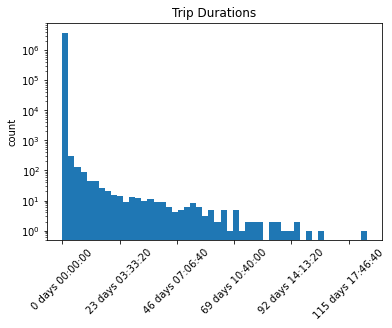

member trips lasting over a day account for 0.013% of all member trips.
casual trips lasting over a day account for 0.035% of all casual trips.


,trip_length,count_member,pct_member,count_casual,pct_casual
0,trip < 1 day,2936866,99.982944,879290,99.847043
1,1 day < trip < 7 days,423,0.014401,1007,0.114349
2,7 days < trip < 30 days,56,0.001906,240,0.027253
3,30 days < trip,22,0.000749,100,0.011355


In [446]:
# Investigate trip_duarations for unrealistic trips

# plot distribution of trip_duraiton with log scale
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = pd.to_timedelta(x, 'sec')                                                                                                                                                                                                                                          
    return str(d) 

x = df_2019['trip_duration']
fig, ax = plt.subplots()
ax.hist(x, bins=50)
plt.yscale("log")
formatter = ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.xaxis.set_major_formatter(formatter)  
plt.xticks(rotation = 45)
plt.title("Trip Durations")
plt.ylabel('count')
plt.show()

# determine percentage of short vs long trips for member/casual users
secs_1day = 24*60*60
secs_7days = secs_in_day*7
secs_30days = secs_in_day*30

trip_durations = {'trip_length':['trip < 1 day','1 day < trip < 7 days', '7 days < trip < 30 days', '30 days < trip']}

for user in ['member', 'casual']:
    df_temp = df_2019[df_2019['user_type'] == user]
    count_1day = sum(df_temp.trip_duration <= secs_1day)
    count_7days = sum((df_temp.trip_duration > secs_1day) & (df_temp.trip_duration <= secs_7days))
    count_30days = sum((df_temp.trip_duration > secs_7days) & (df_temp.trip_duration <= secs_30days))
    count_plus = sum((df_temp.trip_duration > secs_30days))
    counts = np.array([count_1day, count_7days, count_30days, count_plus])
    percents = counts/len(df_temp.trip_duration)*100
    trip_durations['count_%s' %user] = counts
    trip_durations['pct_%s' %user] = percents
    pct_long_trips = round((count_7days+count_30days+count_plus)/len(df_2019.trip_duration)*100, 3)
    print ("{0} trips lasting over a day account for {1:.3}% of all {0} trips.".format(user, pct_long_trips))

df_trip_durations = pd.DataFrame(data=trip_durations)
df_trip_durations


In [475]:
# Select subset of columns to keep
df = df_2019[["trip_id", "start_time", "end_time","trip_duration","user_type", "month", "hour", "day_of_week"]]
# Filter out all trips that lasted >24 hours
df = df[df['trip_duration'] <= secs_1day] 
df.dtypes

trip_id                   int64
start_time       datetime64[ns]
end_time         datetime64[ns]
trip_duration           float64
user_type                object
month                     int64
hour                      int64
day_of_week            category
dtype: object

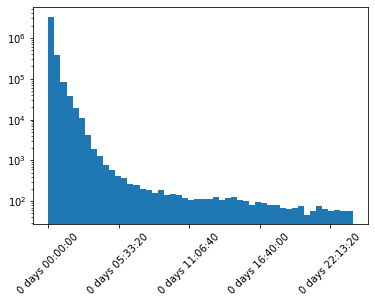

In [448]:
# plot distribution of trip_duraitons <=24 hours with log scale
x = df['trip_duration']
fig, ax = plt.subplots()
ax.hist(x, bins=50)
plt.yscale("log")
formatter = ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.xaxis.set_major_formatter(formatter)  
plt.xticks(rotation = 45)
plt.show()


<Figure size 576x432 with 0 Axes>

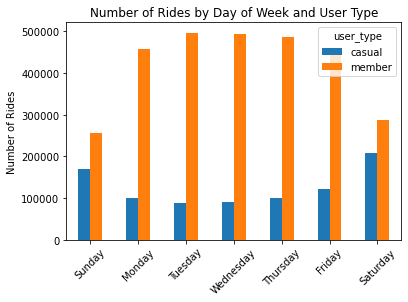

<Figure size 576x432 with 0 Axes>

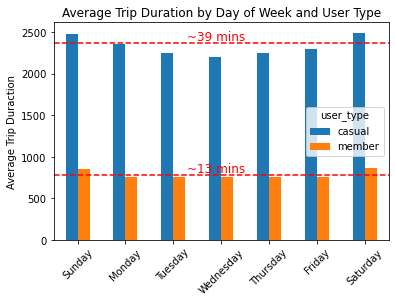

In [449]:
# Data Analysis: Day of Week

# Bar chart of counts grouped by day_of_week and user_type
counts = df.groupby(['day_of_week', 'user_type']).size().unstack()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', stacked=False)
# Add labels
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Day of Week and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


# Bar chart of average trip duration grouped by day_of_week and user_type
avg_duration = df.groupby(['day_of_week', 'user_type'])['trip_duration'].mean().unstack()
plt.figure(figsize=(8, 6))
avg_duration.plot(kind='bar', stacked=False)
# Add horizontal lines at average duration by usertype
avg_dur_member = df[df['user_type']=='member']['trip_duration'].mean()
avg_dur_casual = df[df['user_type']=='casual']['trip_duration'].mean()
avg_dur_member_min = round(avg_dur_member/60)
avg_dur_casual_min = round(avg_dur_casual/60)
plt.axhline(y=avg_dur_member, color='red', linestyle='--')  
plt.text(avg_duration.shape[0] / 2, avg_dur_member, '~{} mins'.format(avg_dur_member_min), color='red', fontsize=12, horizontalalignment='right',verticalalignment='bottom',)  # Add label
plt.axhline(y=avg_dur_casual, color='red', linestyle='--')  
plt.text(avg_duration.shape[0] / 2, avg_dur_casual, '~{} mins'.format(avg_dur_casual_min), color='red', fontsize=12, horizontalalignment='right',verticalalignment='bottom',)  # Add label
# Add labels
plt.ylabel('Average Trip Duraction')
plt.title('Average Trip Duration by Day of Week and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


<Figure size 576x432 with 0 Axes>

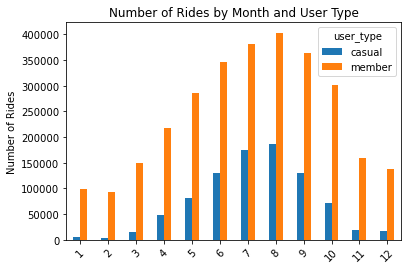

<Figure size 576x432 with 0 Axes>

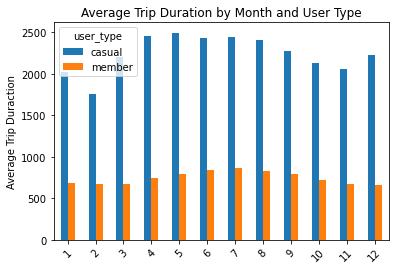

In [450]:
# Data Analysis: Month of Year

# Bar chart of counts grouped by month and user_type
counts = df.groupby(['month', 'user_type']).size().unstack()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', stacked=False)
# Add labels
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Month and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


# Bar chart of average trip duration grouped by month and user_type
avg_duration = df.groupby(['month', 'user_type'])['trip_duration'].mean().unstack()
plt.figure(figsize=(8, 6))
avg_duration.plot(kind='bar', stacked=False)
# Add labels
plt.ylabel('Average Trip Duraction')
plt.title('Average Trip Duration by Month and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


<Figure size 576x432 with 0 Axes>

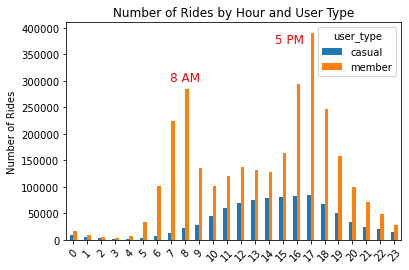

<Figure size 576x432 with 0 Axes>

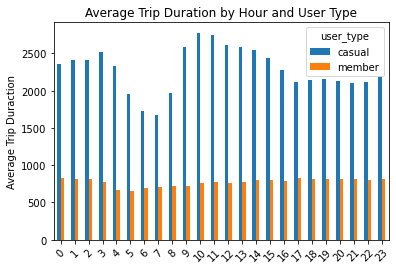

In [466]:
# Data Analysis: Time of Day

# Bar chart of counts grouped by hour and user_type
counts = df.groupby(['hour', 'user_type']).size().unstack()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', stacked=False)
# Add text for peak times
plt.text(8, 300000, '8 AM', color='red', fontsize=12, horizontalalignment='center')
plt.text(16.5, 370000, '5 PM', color='red', fontsize=12, horizontalalignment='right')
# Add labels
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Hour and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()


# Bar chart of average trip duration grouped by hour and user_type
avg_duration = df.groupby(['hour', 'user_type'])['trip_duration'].mean().unstack()
plt.figure(figsize=(8, 6))
avg_duration.plot(kind='bar', stacked=False)
# Add labels
plt.ylabel('Average Trip Duraction')
plt.title('Average Trip Duration by Hour and User Type')
plt.xticks(rotation=45)
plt.xlabel('')
plt.show()